# imports and params

In [1]:
#https://www.kaggle.com/allunia/protein-atlas-exploration-and-baseline
#https://www.kaggle.com/allunia/in-depth-protein-correlations

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.sys.path.append('../fastai/') #fastai version 1
import fastai
from fastai import *

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import uuid

import seaborn as sns
sns.set()


DP = Path('/home/Deep_Learner/work/network/datasets/human-protein-atlas-image-classification/')
DP_FULL = Path('/home/Deep_Learner/shared/Datasets/human-protein-atlas-image-classification/')
STAGE_ONE_DATA = DP/'stage1_data'
TRAIN_PNGS = 'train_pngs_512'
TRAIN_PNGS_FULL = 'train_pngs_full_size'
TRAIN_PNGS_MULTI = 'train_pngs_512_oversampled'
TEST_PNGS = 'test_pngs_512'
TEST_PNGS_FULL = 'test_pngs_full_size'
TRAIN_CSV = 'train.csv'
TRAIN_CSV_MULTI = 'train_oversampled_only.csv'
TRAIN_CSV_MULTI_AND_ORIG = 'train_oversampled_and_original.csv'
LBS_BALANCED = 'lbs_balanced.csv'
EXTRA_HPA_DATA_CSV = STAGE_ONE_DATA/'extra_data.csv'
EXTRA_HPA_DATA_WITHOUT_BROKEN_AND_MISSING_CSV = STAGE_ONE_DATA/'extra_data_without_broken_and_missing_pngs_512.csv'
BASE_AND_EXTRA_CSV = STAGE_ONE_DATA/'base_and_extra_data_without_broken_and_missing.csv'
EXTRA_DATA_PNGS = STAGE_ONE_DATA/'extra_HPAv18_pngs_512'

label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_label_names = dict((v,k) for k,v in label_names.items())
sz = 512

# Labels distrib.

## functions

In [33]:
def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

def get_labels_distribution(df:pd.DataFrame):
    df_copy = df.copy()
    for key in label_names.keys():
        df_copy[label_names[key]] = 0
    df_copy = df_copy.apply(fill_targets, axis=1)
    target_counts = df_copy.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
    plt.figure(figsize=(15,15))
    sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)
    return target_counts

## base data

In [3]:
train_labels = pd.read_csv(STAGE_ONE_DATA/TRAIN_CSV)
train_labels.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


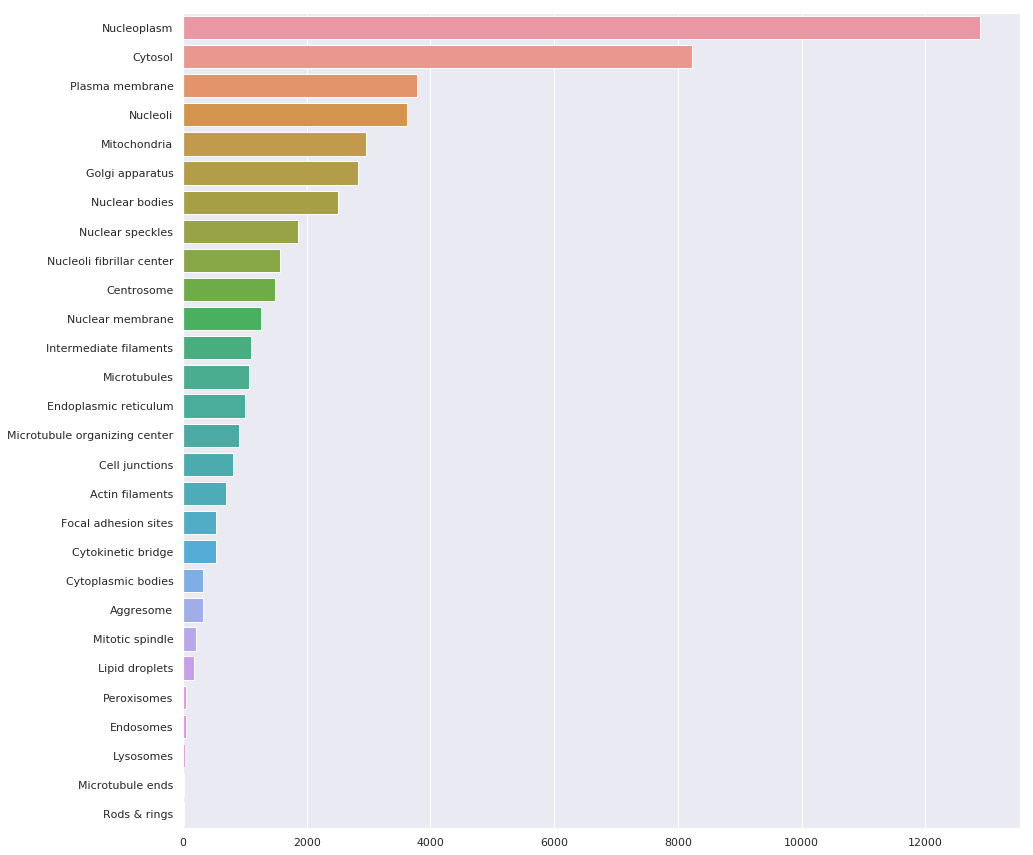

In [5]:
target_counts = get_labels_distribution(train_labels)

In [6]:
target_counts

Nucleoplasm                      12885
Cytosol                           8228
Plasma membrane                   3777
Nucleoli                          3621
Mitochondria                      2965
Golgi apparatus                   2822
Nuclear bodies                    2513
Nuclear speckles                  1858
Nucleoli fibrillar center         1561
Centrosome                        1482
Nuclear membrane                  1254
Intermediate filaments            1093
Microtubules                      1066
Endoplasmic reticulum             1008
Microtubule organizing center      902
Cell junctions                     802
Actin filaments                    688
Focal adhesion sites               537
Cytokinetic bridge                 530
Cytoplasmic bodies                 328
Aggresome                          322
Mitotic spindle                    210
Lipid droplets                     172
Peroxisomes                         53
Endosomes                           45
Lysosomes                

## extra hpa data

In [35]:
extra_data_labels = pd.read_csv(EXTRA_HPA_DATA_WITHOUT_BROKEN_AND_MISSING_CSV)
extra_data_labels.head()

,Id,Target
0,10580_1610_C1_1,13 25 0 2 21
1,10580_1610_C1_2,13 25 0 2 21
2,10580_1756_B1_1,13 25 0 2 21
3,10580_1756_B1_2,13 25 0 2 21
4,10580_1758_B1_1,13 25 0 2 21


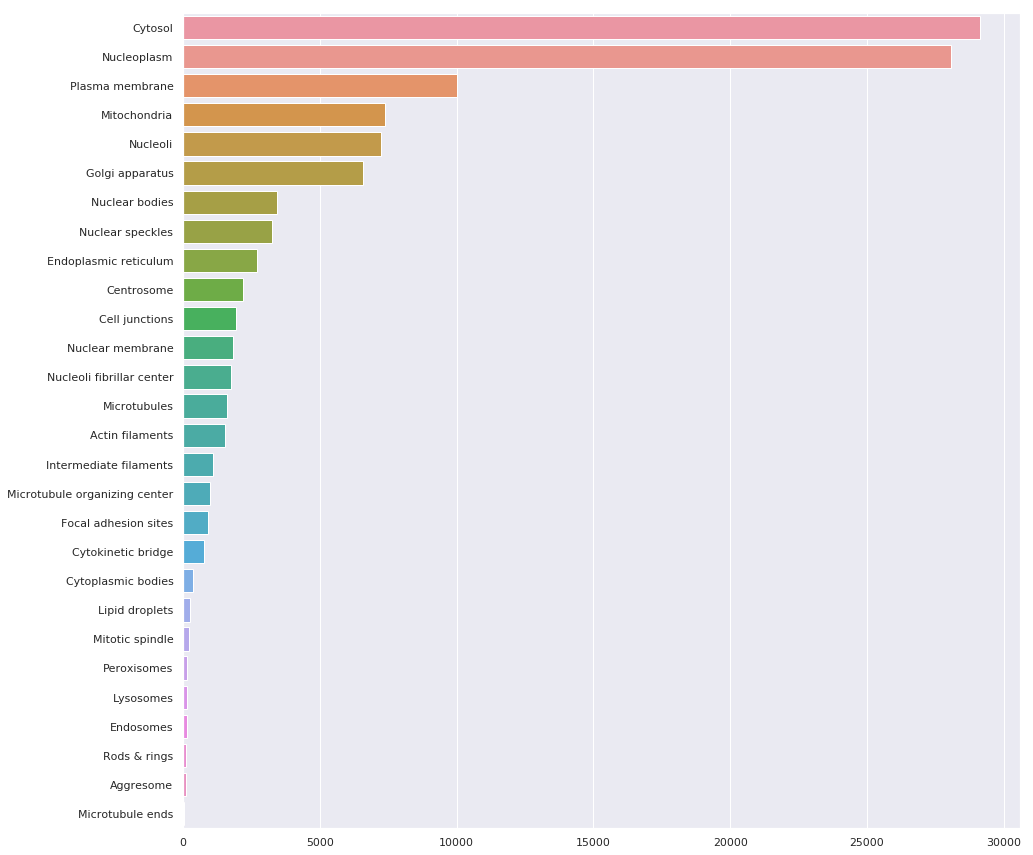

In [36]:
extra_data_target_counts = get_labels_distribution(extra_data_labels)

In [37]:
extra_data_target_counts

Cytosol                          29132
Nucleoplasm                      28070
Plasma membrane                  10032
Mitochondria                      7380
Nucleoli                          7249
Golgi apparatus                   6581
Nuclear bodies                    3424
Nuclear speckles                  3271
Endoplasmic reticulum             2715
Centrosome                        2189
Cell junctions                    1927
Nuclear membrane                  1818
Nucleoli fibrillar center         1768
Microtubules                      1624
Actin filaments                   1545
Intermediate filaments            1100
Microtubule organizing center      991
Focal adhesion sites               921
Cytokinetic bridge                 760
Cytoplasmic bodies                 376
Lipid droplets                     266
Mitotic spindle                    236
Peroxisomes                        164
Lysosomes                          154
Endosomes                          152
Rods & rings             

## base and extra data

In [6]:
base_extra_labels = pd.read_csv(BASE_AND_EXTRA_CSV)
base_extra_labels.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


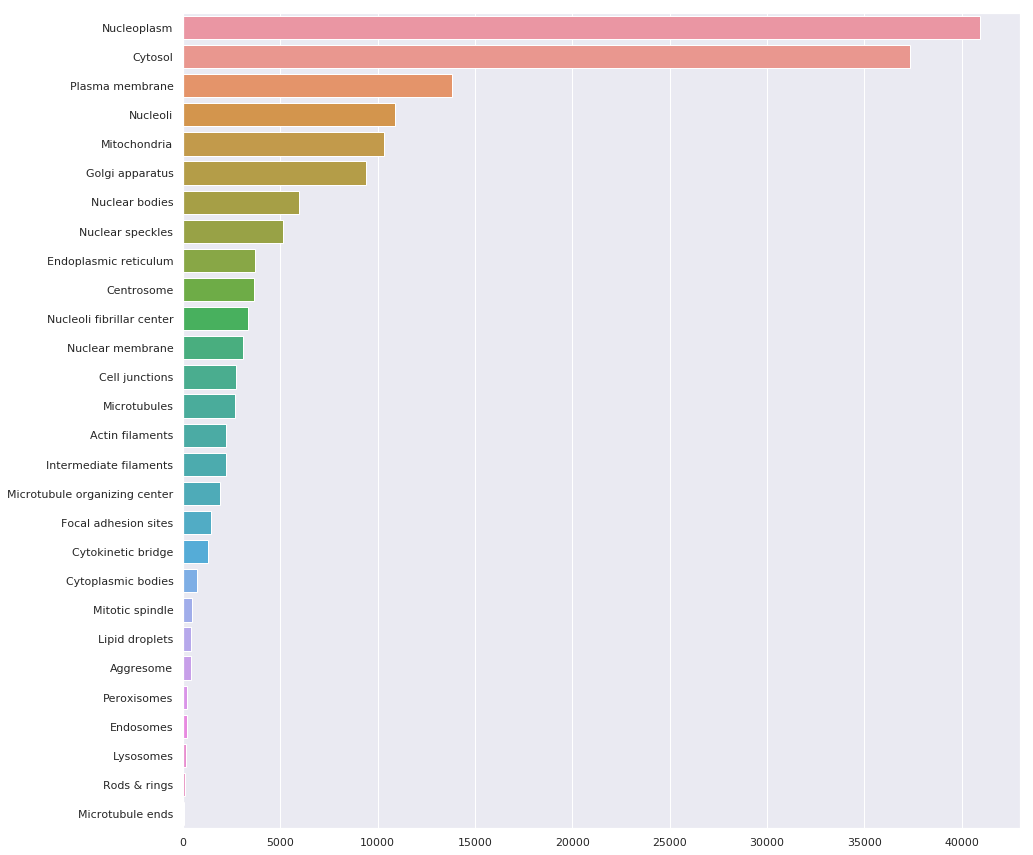

In [7]:
base_extra_target_counts = get_labels_distribution(base_extra_labels)

In [8]:
base_extra_target_counts

Nucleoplasm                      40955
Cytosol                          37360
Plasma membrane                  13809
Nucleoli                         10870
Mitochondria                     10345
Golgi apparatus                   9403
Nuclear bodies                    5937
Nuclear speckles                  5129
Endoplasmic reticulum             3723
Centrosome                        3671
Nucleoli fibrillar center         3329
Nuclear membrane                  3072
Cell junctions                    2729
Microtubules                      2690
Actin filaments                   2233
Intermediate filaments            2193
Microtubule organizing center     1893
Focal adhesion sites              1458
Cytokinetic bridge                1290
Cytoplasmic bodies                 704
Mitotic spindle                    446
Lipid droplets                     438
Aggresome                          427
Peroxisomes                        217
Endosomes                          197
Lysosomes                

## base_and_extra_data(only_cls:[8, 9, 10, 15, 17, 20, 24, 26, 27])_without_broken_and_missing_pngs_512.csv

In [83]:
lab = pd.read_csv(STAGE_ONE_DATA/'base(all_cls)_and_extra_data(only_cls:[8, 9, 10, 15, 17, 20, 24, 26, 27])_without_broken_and_missing_pngs_512.csv')

In [84]:
lab.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


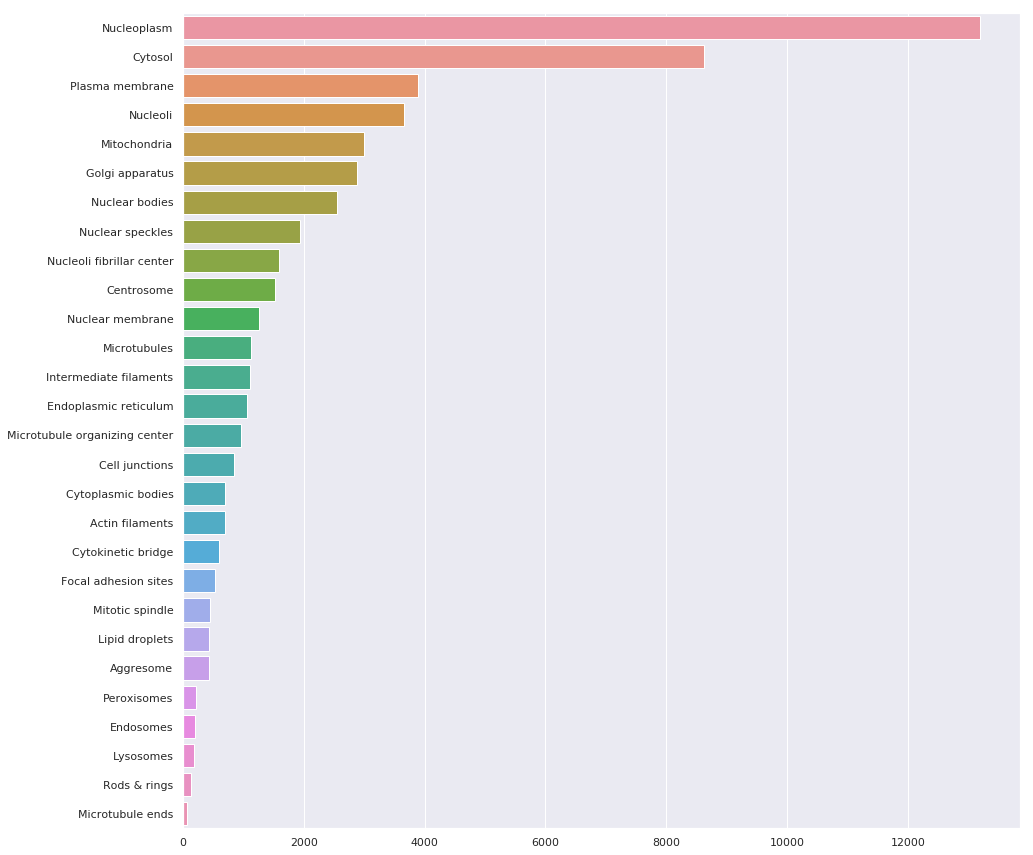

In [87]:
counts = get_labels_distribution(lab)

In [88]:
counts

Nucleoplasm                      13197
Cytosol                           8632
Plasma membrane                   3891
Nucleoli                          3655
Mitochondria                      2993
Golgi apparatus                   2874
Nuclear bodies                    2545
Nuclear speckles                  1941
Nucleoli fibrillar center         1591
Centrosome                        1528
Nuclear membrane                  1254
Microtubules                      1128
Intermediate filaments            1102
Endoplasmic reticulum             1060
Microtubule organizing center      960
Cell junctions                     846
Cytoplasmic bodies                 704
Actin filaments                    700
Cytokinetic bridge                 604
Focal adhesion sites               537
Mitotic spindle                    446
Lipid droplets                     438
Aggresome                          427
Peroxisomes                        217
Endosomes                          197
Lysosomes                

## Specify multiplication factors for oversampling

In [18]:
multi = [1,1,1,1,1,1,1,1,2,2,3,1,1,1,1,5,1,1,1,1,1,1,1,1,1,1,1,4]
len(multi)

rare_cls = []
for n, i in enumerate(multi):
    if i>1:
        c = label_names[n]
        print(f'{c} x{i}')
        rare_cls.append(c)

Peroxisomes x2
Endosomes x2
Lysosomes x3
Microtubule ends x5
Rods & rings x4


# Move only rare classes from extra data into new folder and create new csv

In [6]:
name = 'extra_data(only_cls:[8, 9, 10, 15, 17, 20, 24, 26, 27])_without_broken_and_missing_pngs_512'
newFolder = STAGE_ONE_DATA/name
newDfName = f'{name}.csv'
newCombinedDfName = f'base(all_cls)_and_{name}.csv'
newDf = pd.DataFrame(columns=['Id', 'Target']);newDf

,Id,Target


In [70]:
cls = ["Microtubule ends", 
           'Rods & rings',
           'Cytoplasmic bodies',                 
            'Mitotic spindle',                 
            'Lipid droplets',                 
            'Aggresome',                 
            'Peroxisomes',                 
            'Endosomes',                 
            'Lysosomes']

In [71]:
ä=[]
for c in cls:
    ä.append(reverse_label_names[c])
sorted(ä)

[8, 9, 10, 15, 17, 20, 24, 26, 27]

In [72]:
df = pd.read_csv(STAGE_ONE_DATA/EXTRA_HPA_DATA_WITHOUT_BROKEN_AND_MISSING_CSV);df.head()

,Id,Target
0,10580_1610_C1_1,13 25 0 2 21
1,10580_1610_C1_2,13 25 0 2 21
2,10580_1756_B1_1,13 25 0 2 21
3,10580_1756_B1_2,13 25 0 2 21
4,10580_1758_B1_1,13 25 0 2 21


In [24]:
ids_list = get_rare_cls_id_list(rare_cls=cls, df=df)

In [32]:
for c in cls:
    print(len(get_rare_cls_id_list(rare_cls=[c], df=df)))

42
116
376
236
266
105
164
152
154


In [75]:
import shutil

for n, id_ in enumerate(ids_list):
    try:
        colors = ['red','green','blue','yellow']
        for c in colors:
            shutil.copyfile(EXTRA_DATA_PNGS/f'{id_}_{c}.png', newFolder/f'{id_}_{c}.png')
            
        target = df.loc[df.Id == id_].Target.item()
        newDf = newDf.append({'Id':id_, 'Target':target}, ignore_index=True)
    except:
        print(id_)
        
newDf.to_csv(STAGE_ONE_DATA/newDfName, index=False)

In [79]:
len(ids_list)*4

5948

In [80]:
len(list(newFolder.iterdir()))

5948

# Split train into train and val for each class

In [60]:
#with open(os.path.join(STAGE_ONE_DATA,'tr_names.txt'), 'r') as text_file:
#    tr_n = text_file.read().split(',')
#with open(os.path.join(STAGE_ONE_DATA,'val_names.txt'), 'r') as text_file:
#    val_n = text_file.read().split(',')
#
#pd.DataFrame(tr_n, columns=['Id']).to_csv(STAGE_ONE_DATA/'tr_names.csv', index=False)
#pd.DataFrame(val_n, columns=['Id']).to_csv(STAGE_ONE_DATA/'val_names.csv', index=False)

In [61]:
from sklearn.model_selection import train_test_split
#tr_n, val_n = train_test_split(train_names, test_size=0.2, random_state=42) #split train set into train and val set

In [104]:
tr_n = [] 
val_n = []
df_extra = pd.read_csv(STAGE_ONE_DATA/newDfName)
for c in reverse_label_names:
    print(c)
    l = get_rare_cls_id_list([c], df=df_extra)
    
    print(len(l))
    for i in l:
        if i in tr_n:
            l.remove(i)
        if i in val_n:
            l.remove(i)
    print(len(l))
    
    t, v = train_test_split(l, test_size=0.2, random_state=42)    
    for item in t:
        tr_n.append(item)
    for item in v:
        val_n.append(item)
        
#tr_n = list(set(tr_n))
#val_n = list(set(val_n))

Nucleoplasm
312
312
Nuclear membrane
0
0
Nucleoli
34
34
Nucleoli fibrillar center
30
30
Nuclear speckles
83
80
Nuclear bodies
32
23
Endoplasmic reticulum
52
52
Golgi apparatus
52
52
Peroxisomes
164
149
Endosomes
152
144
Lysosomes
154
87
Intermediate filaments
9
9
Actin filaments
12
9
Focal adhesion sites
0
0
Microtubules
62
57
Microtubule ends
42
36
Cytokinetic bridge
74
40
Mitotic spindle
236
159
Microtubule organizing center
58
37
Centrosome
46
23
Lipid droplets
266
215
Plasma membrane
114
76
Cell junctions
44
27
Mitochondria
28
20
Aggresome
105
73
Cytosol
404


ValueError: list.remove(x): x not in list

In [105]:
len(df_extra)

1487

In [106]:
len(tr_n) + len(val_n)

1744

In [107]:
len(set(tr_n)) + len(set(val_n))

1464

# multiply rare classes in df (obsolete)

In [147]:
lbs_balanced = pd.read_csv(STAGE_ONE_DATA/LBS_BALANCED)

In [148]:
lbs_balanced.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
def multiply_rare_classes(rare_cls:list, multi_fac:int, df:pd.DataFrame):
    for index, row in df.iterrows():
        s = str(row['Target'])
        sl = s.split(sep=' ')
        il = [int(st) for st in sl]
        ls = [label_names[l] for l in il]
        if bool(set(ls) & set(rare_cls)):
            #print('true')
            for i in range(multi_fac):
                df = df.append(row)
    return df

In [162]:
rare_classes = ['Rods & rings']
#rare_classes = ['Microtubule ends', 'Nucleoli fibrillar center', 'Centrosome', 'Rods & rings']

In [157]:
rare_classes

['Microtubule organizing center', 'Microtubules']

In [158]:
lbs_balanced = multiply_rare_classes(rare_cls=rare_classes, multi_fac=2, df = lbs_balanced)

In [159]:
t = get_labels_distribution(lbs_balanced)

In [160]:
t

Nucleoplasm                      26321
Cytosol                          14541
Nucleoli                          7162
Plasma membrane                   6788
Mitotic spindle                   6060
Nuclear membrane                  5612
Microtubule organizing center     5448
Microtubules                      5439
Intermediate filaments            5292
Nuclear bodies                    5112
Cell junctions                    4635
Cytokinetic bridge                4183
Mitochondria                      4060
Actin filaments                   3985
Golgi apparatus                   3499
Aggresome                         3352
Focal adhesion sites              3170
Cytoplasmic bodies                2880
Endosomes                         2845
Lysosomes                         2828
Nuclear speckles                  2778
Peroxisomes                       2703
Lipid droplets                    2580
Endoplasmic reticulum             2306
Rods & rings                      2211
Centrosome               

In [161]:
lbs_balanced.to_csv(STAGE_ONE_DATA/LBS_BALANCED, index=False)

# Oversample rare classes

In [3]:
def get_rare_cls_id_list(rare_cls:list, df:pd.DataFrame):
    result = []
    for index, row in df.iterrows():
        s = str(row['Target'])
        sl = s.split(sep=' ')
        il = [int(st) for st in sl]
        ls = [label_names[l] for l in il]
        if bool(set(ls) & set(rare_cls)):
            #print(row)
            result.append(row['Id'])
    return result

def open_rgby(path,id):
    """
    a function that reads RGBY image
    """
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)
    
def open_four_channels_and_save_with_new_id(load_path, load_id, save_path):
    """
    A function that reads the four images belonging to one id and saving them unchanged with a new id.
    
    #Arguments:
        load_path: folder_path
        load_id: id without the color suffix
        save_path: folder_path
    
    #Returns:
        new_id: The new new Id as a string.
        imgs: list of the four grayscale, one channel images
    """
    new_id = str(uuid.uuid4())
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    imgs = [cv2.imread(os.path.join(load_path, load_id+'_'+color+'.png'), flags)
           for color in colors]
    for img, col in zip(imgs, colors):
        cv2.imwrite(f'{save_path}/{new_id}_{col}.png', img)
    return new_id, imgs

def display_img_gray(img):
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.show()
    
def display_img_col(img):
    pass

In [6]:
#new_id, imgs = open_four_channels_and_save_with_new_id(load_path=STAGE_ONE_DATA/TRAIN_PNGS, 
#                                               save_path=STAGE_ONE_DATA/TRAIN_PNGS_MULTI, 
#                                               load_id='05d32f36-bba3-11e8-b2b9-ac1f6b6435d0')
#new_id, imgs = open_four_channels_and_save_with_new_id(load_path=DP_FULL/TRAIN_PNGS_FULL, 
#                                               save_path=STAGE_ONE_DATA/TRAIN_PNGS_MULTI, 
#                                               load_id='05d32f36-bba3-11e8-b2b9-ac1f6b6435d0')
#for img in imgs:
#    print(img.shape)
#    display_img_gray(img)
#
#    
#img1 = open_rgby(path=STAGE_ONE_DATA/TRAIN_PNGS, 
#                 id='05d32f36-bba3-11e8-b2b9-ac1f6b6435d0')
#img2 = open_rgby(path=STAGE_ONE_DATA/TRAIN_PNGS_MULTI,
#                 id=new_id)
#
#plt.imshow(img1)
#plt.show()
#plt.imshow(img2)
#plt.show()

In [7]:
#rare_classes = ['Rods & rings', 'Microtubule ends', 'Lysosomes']
rare_classes = []
result = get_rare_cls_id_list(rare_cls=rare_classes, df=train_labels)

In [8]:
result

[]

In [9]:
train_labels = pd.read_csv(STAGE_ONE_DATA/TRAIN_CSV)
#train_multi_df = pd.DataFrame(columns=['Id', 'Target'])
train_multi_df = pd.read_csv(STAGE_ONE_DATA/TRAIN_CSV_MULTI)

Nucleoplasm                      17678
Cytosol                          10142
Nucleoli                          4884
Plasma membrane                   4857
Nuclear bodies                    3575
Mitochondria                      3445
Golgi apparatus                   3039
Cell junctions                    2464
Cytoplasmic bodies                2310
Nuclear speckles                  2220
Actin filaments                   2152
Lipid droplets                    1892
Nucleoli fibrillar center         1801
Centrosome                        1716
Focal adhesion sites              1669
Endoplasmic reticulum             1630
Aggresome                         1620
Cytokinetic bridge                1510
Mitotic spindle                   1472
Endosomes                         1445
Lysosomes                         1428
Peroxisomes                       1378
Microtubules                      1374
Nuclear membrane                  1314
Microtubule organizing center     1302
Intermediate filaments   

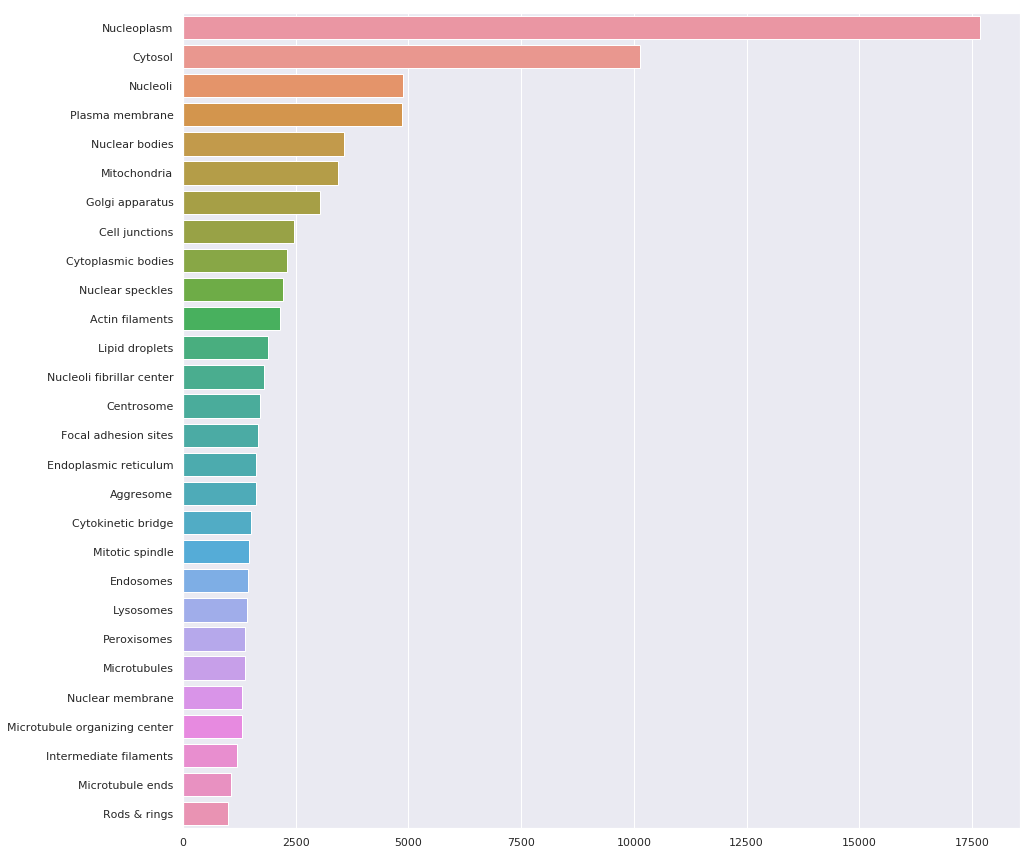

In [67]:
for n in range(2):
    for i in result:
        target = train_labels.loc[train_labels.Id == i].Target.item()
        new_id, _ = open_four_channels_and_save_with_new_id(load_path=STAGE_ONE_DATA/TRAIN_PNGS, 
                                                   save_path=STAGE_ONE_DATA/TRAIN_PNGS_MULTI, 
                                                   load_id=i)
        train_multi_df = train_multi_df.append({'Id':new_id, 'Target':target}, ignore_index=True)
        
train_multi_df.to_csv(path_or_buf=STAGE_ONE_DATA/TRAIN_CSV_MULTI, index=False)
train_multi_and_original_df = train_labels.append(train_multi_df, ignore_index=True, sort=False)
train_multi_and_original_df.shape[0]-train_multi_df.shape[0] == train_labels.shape[0]
get_labels_distribution(train_multi_and_original_df)

In [69]:
train_multi_and_original_df.to_csv(STAGE_ONE_DATA/ TRAIN_CSV_MULTI_AND_ORIG, index=False)

In [13]:
#train_multi_and_original_df = pd.read_csv(STAGE_ONE_DATA/ TRAIN_CSV_MULTI_AND_ORIG)
train_multi_and_original_df.shape[0]

46127

In [14]:
len(list((STAGE_ONE_DATA/TRAIN_PNGS_MULTI).iterdir()))/4

46127.0

In [12]:
len(list((STAGE_ONE_DATA/TRAIN_PNGS).iterdir()))/4

31072.0

In [99]:
train_multi_and_original_df.shape[0] - train_multi_df.shape[0] == train_labels.shape[0]

True